# 1. Install Necessary Libraries

In [20]:
%%capture --no-stderr
%pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchainhub chromadb langchain langgraph  tavily-python

# 2. Import necessary dependencies and set environment variables

In [48]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG

Large Language Models (LLMs) have demonstrated impressive capabilities in generating human-like text, but they are limited by the data they were trained on. This is where Retrieval Augmented Generation (RAG) comes in. RAG enhances LLMs by allowing them to access and incorporate external knowledge sources, leading to more accurate, relevant, and grounded responses. This blog post will explore the four core areas of RAG: Indexing & Embedding, Retrieval, Augmentation through Prompting, and Generation.

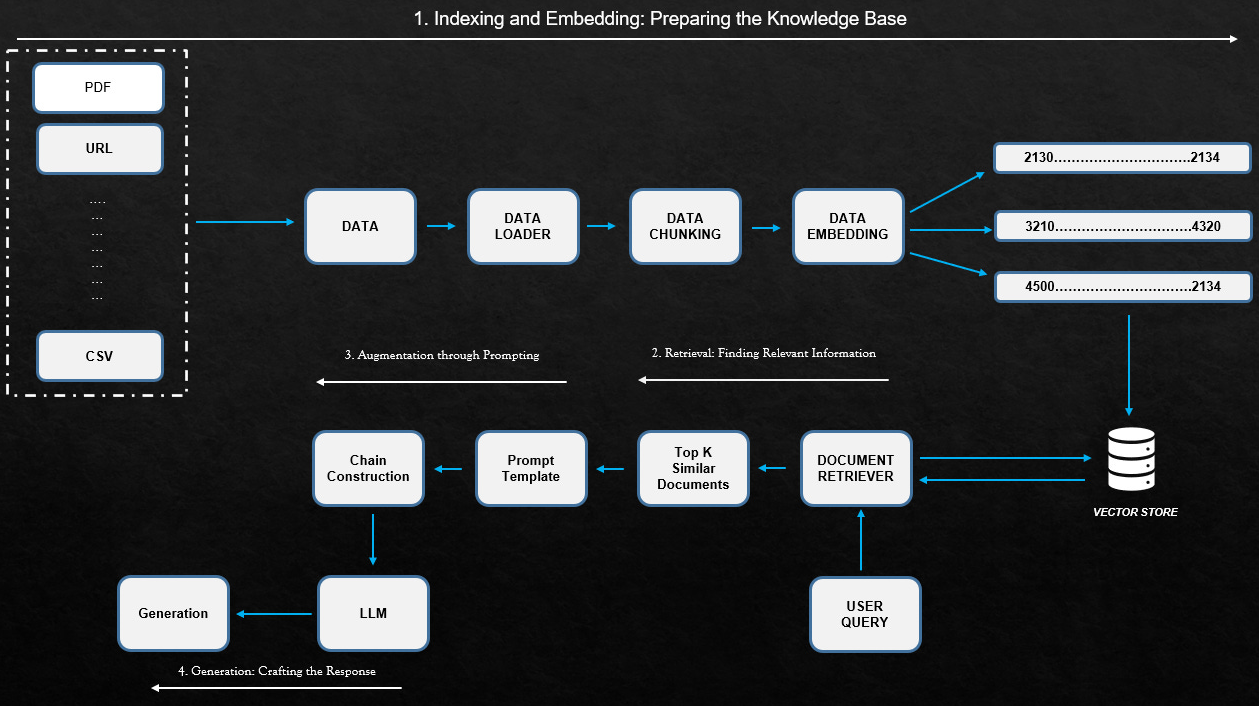

Detailed Blog :  https://aiproductplaybook.substack.com/p/2-rag-high-level-design

# 3. Corrective RAG ( CRAG)

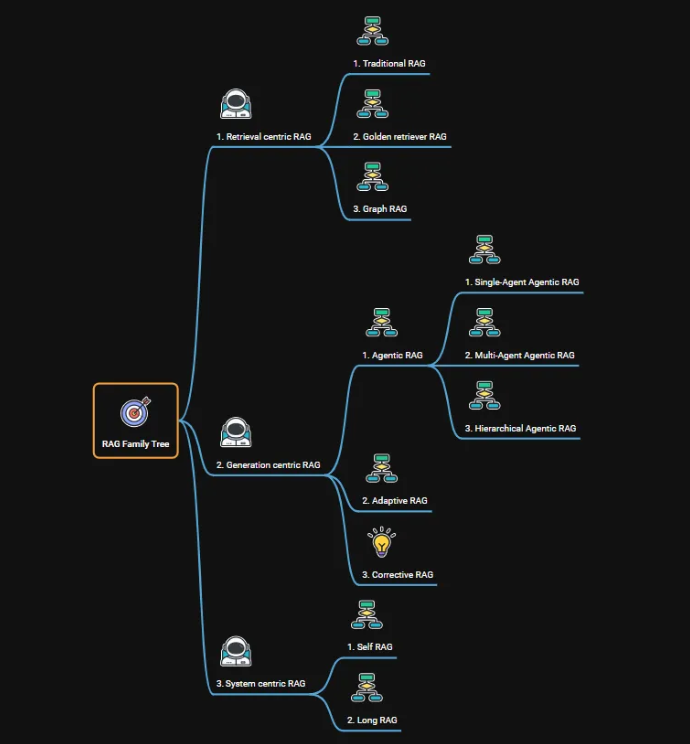

Detailed Blog : https://aiproductplaybook.substack.com/p/810-what-the-heck-are-corrective

### a. Corrective RAG

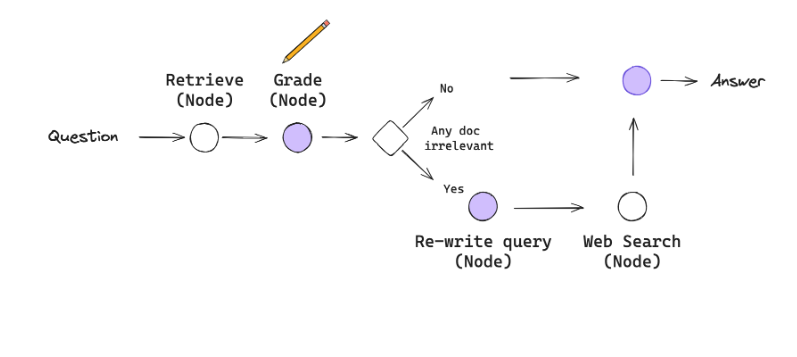

### b. Index the Knowledge Base

1. Import necessary dependencies

2. URLs : This list contains the URLs of the web pages you want to load.

3. Loading Web Pages

a. docs = [WebBaseLoader(url).load() for url in urls]: This uses a list comprehension to load the content of each URL using WebBaseLoader. The result is a list of lists, where each inner list contains the documents loaded from a single URL.

b. docs_list = [item for sublist in docs for item in sublist]: This flattens the list of lists into a single list of documents.

4. Text Splitting

a. text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(...): Creates a RecursiveCharacterTextSplitter object. This splitter recursively breaks down the text into chunks.

chunk_size=100: Specifies that each chunk should ideally be around 100 characters long.

chunk_overlap=50: Specifies that there should be a 50-character overlap between consecutive chunks. This helps preserve context across chunks.

from_tiktoken_encoder: This is an efficient way to count tokens, ensuring that chunks are split based on token count (which is more relevant for LLMs) rather than just character count. It requires the tiktoken library to be installed.

b. doc_splits = text_splitter.split_documents(docs_list): Splits the loaded documents into chunks using the configured text splitter.

5. Creating the Vector Database

a. vectorstore = Chroma.from_documents(...): Creates a Chroma vector database from the document chunks.

documents=doc_splits: Provides the list of document chunks.

collection_name="rag-chroma": Gives a name to the Chroma collection.

embedding=OpenAIEmbeddings(): Specifies that OpenAI's embeddings model should be used to create vector representations of the text chunks. This requires an OpenAI API key to be set as an environment variable (OPENAI_API_KEY).

b. retriever = vectorstore.as_retriever(): Creates a retriever object from the vector database. The retriever is used to fetch relevant chunks of text based on a query.

Summary

This code loads web pages, splits them into smaller, overlapping chunks using a tiktoken aware splitter, and then creates a Chroma vector database from these chunks.  It uses OpenAI embeddings to create vector representations of the text, which are stored in the vector database.  Finally, it creates a retriever, which can be used to efficiently retrieve relevant context from the documents based on a user's query. This setup is essential for building RAG applications, where relevant information is retrieved from a knowledge base to augment the capabilities of a large language model.

In [22]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

### c. Define the Retrieval Grader

This code defines a component for grading the relevance of a single retrieved document to a given question. It uses an LLM with structured output to get a "yes" or "no" score.  The GradeDocuments Pydantic model ensures that the LLM's output is correctly formatted.  This grader can be used to filter out irrelevant documents in a RAG pipeline, but the example code only grades one document.  In a real application, you would likely loop through all the retrieved documents and grade each one individually.

In [50]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### d. Define the Generate component

This code generates an answer to a question using retrieved documents and a pre-built RAG (Retrieval Augmented Generation) prompt from the LangChain Hub

How it works:

1. The rag_chain.invoke() method is called with the context and question.

2. The prompt object formats the input into the "rlm/rag-prompt" template. This template likely inserts the context and question into specific places within the prompt.

3. The formatted prompt is passed to the llm object.

4. The LLM generates a response.

5. The StrOutputParser converts the LLM's response to a string.

6. The resulting string (the answer) is returned and stored in the generation variable.

7. The answer is printed.



In [51]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory in LLM-powered autonomous systems consists of short-term and long-term memory components. Short-term memory utilizes in-context learning for immediate tasks, while long-term memory allows agents to retain and recall information over extended periods, often using external databases for storage. This memory structure enables agents to learn from past experiences and improve their interactions and decision-making processes.


### e. Define the Question Re-writer

This code defines a component that takes a user question and uses an LLM to rewrite it for better web search performance. The LLM is instructed to focus on preserving the semantic meaning while making the question more suitable for search engines. The use of StrOutputParser ensures that the output is a string, which is often required by web search tools.  The rewritten question can then be passed to a web search tool to get more relevant results.

In [52]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the role of memory in artificial intelligence agents?'

### f. Define the Web search tool

This code creates a tool called web_search_tool that, when invoked, will perform a web search using the Tavily API and return the 3 most relevant results.  This tool can then be integrated into LangChain agents or chains to add web search capabilities to their workflow.

In [53]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### g. Define the Graph states

The GraphState TypedDict defines a structured way to represent the state within a graph-based application. It holds the question, the LLM's generation, a flag for whether to use web search, and a list of documents. Using a TypedDict makes the code more readable and maintainable by clearly defining the structure and types of data stored in the graph's state.  It also enables static analysis tools to catch type-related errors.

The docstring ("""...""") describes the purpose of GraphState and lists its attributes:

question: str: The user's original question, stored as a string.

generation: str: The LLM's generated output or answer, stored as a string.

web_search: str: A string indicating whether web search results should be incorporated. This is likely a "yes" or "no" value (or perhaps something more nuanced).

documents: List[str]: A list of relevant documents (or their content as strings).

In [54]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

### h.Define the functions and logic for a Retrieval Augmented Generation (RAG) pipeline

1. retrieve(state):

Purpose: Retrieves documents based on the question.

Logic:

a. Prints "---RETRIEVE---".

b. Extracts the question from the state dictionary.

c. Uses a retriever object (assumed to be defined elsewhere) to fetch relevant documents.

d. Returns a new dictionary containing the retrieved documents and the original question.

2. generate(state):

Purpose: Generates an answer using the retrieved documents and the question.

Logic:

a. Prints "---GENERATE---".

b. Extracts the question and documents from the state.

c. Uses a rag_chain (a LangChain chain for RAG, assumed to be defined elsewhere) to generate the answer.

d. Returns a new dictionary containing the documents, question, and the generated generation.

3. grade_documents(state):

Purpose: Grades the relevance of retrieved documents to the question.

Logic:

a. Prints "---CHECK DOCUMENT RELEVANCE TO QUESTION---".

b. Extracts question and documents from the state.

c. Initializes filtered_docs (a list to hold relevant documents) and web_search to "No".

d. Iterates through each document:

Uses a retrieval_grader (assumed to be defined elsewhere) to score the document's relevance.

If the binary_score is "yes":

Prints "---GRADE: DOCUMENT RELEVANT---".

Appends the document to filtered_docs.

If the binary_score is "no":

Prints "---GRADE: DOCUMENT NOT RELEVANT---".

Sets web_search to "Yes". This is a flag indicating that at least one document was deemed irrelevant, which might trigger a web search later.

Continues to the next document.

Returns a new dictionary containing the filtered_docs (now the documents key), the original question, and the web_search flag.

4. transform_query(state):

Purpose: Rewrites the question to improve retrieval effectiveness.

Logic:

a. Prints "---TRANSFORM QUERY---".

b. Extracts question and documents from the state.

c. Uses a question_rewriter (assumed to be defined elsewhere) to generate a better_question.

d. Returns a new dictionary with the question key updated to the better_question, and the original documents.

5. web_search(state):

Purpose: Performs a web search based on the question.

Logic:

a. Prints "---WEB SEARCH---".

b. Extracts the question and documents from the state.

c. Uses a web_search_tool (assumed to be a LangChain tool) to perform the search.

d. Formats web search results into a LangChain Document object.

e. Appends the web search results to the existing documents list.

f. Returns a new dictionary containing the updated documents list and the original question.

6. decide_to_generate(state):

Purpose: Decides whether to generate an answer or transform the query.

Logic:

a. Prints "---ASSESS GRADED DOCUMENTS---".

b. Extracts web_search and documents from the state.

c. If web_search is "Yes" (meaning some documents were irrelevant):

Prints a message indicating query transformation.

Returns "transform_query".

Otherwise (all documents were relevant or no documents were retrieved):

Prints a message indicating generation.

Returns "generate".

These functions define the steps and logic for a RAG pipeline with document grading and optional web search.  The web_search flag allows the system to fall back to web search if the initially retrieved documents are not sufficiently relevant. The appending of web search results to the document list allows the generation step to consider both retrieved documents and web search results.  These functions would be orchestrated within a LangChain graph to create the complete RAG workflow.

In [55]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### i. Define and Visualize the Graph

In [56]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

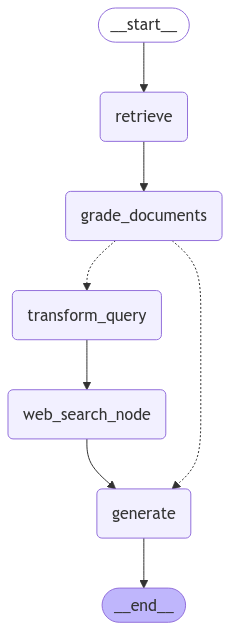

In [57]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### g. Invoke the RAG

In [58]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The different categories of memory in agents include short-term memory, '
 'which involves in-context learning, and long-term memory, which allows for '
 'the retention and recall of information over extended periods. Additionally, '
 'there are types of long-term memory such as semantic memory, which stores '
 'knowledge about the world and the agent itself, and procedural memory, which '
 "represents the agent's procedures for decision-making and actions. These "
 'memory typ

In [59]:
from pprint import pprint

# Run
inputs = {"question": "Who won the Golden ball in Men's Football world cup 2022?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
("Lionel Messi was awarded the Golden Ball in the Men's FIFA World Cup 2022. "
 'He became the first player to win the Golden Ball twice, having previously '
 "won it in 2014. Messi's performance included 7 goals and 3 assists, "
 "contributing to Argentina's victory.")


In [60]:
from pprint import pprint

# Run
inputs = {"question": "Who won the men's singles wimbledon open 2024?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
("Carlos Alcaraz emerged victorious in the men's singles event at the 2024 "
 'Wimbledon Open, defeating Novak Djokovic with a score of 6–2, 6–2, 7–6(7–4). '
 "This victory marked Alcaraz's second Wimbledon title and his fourth major "
 'title overall.')


In [61]:
from pprint import pprint

# Run
inputs = {"question": "What are the different types of Task Decomposition?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Tasks can be broken down into smaller components using several methods: (1) '
 'prompting a large language model (LLM) with specific questions or '
 'instructions, (2) utilizing task-specific guidelines, and (3) incorporating '
 'human inputs for additional context. Additionally, techniques like '
 'microproductivity and prioritization can help manage and organize these '
 'smaller tasks effectively. These methods enhance efficiency and reduce '
 'stress in project management.'

In [62]:
from pprint import pprint

# Run
inputs = {"question": "What is Self Reflection?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Self-reflection is a crucial process that enables autonomous agents to '
 'improve by analyzing past actions, correcting mistakes, and refining their '
 'decision-making. It involves learning from trial and error, which is '
 'essential for enhancing performance in real-world tasks. This iterative '
 "improvement is facilitated by integrating reflections into the agent's "
 'working memory for future guidance.')


In [63]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of CoT prompts?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The context mentions two main types of Chain-of-Thought (CoT) prompts, but '
 'it does not specify what they are. It also lists various related concepts '
 'such as Automatic Prompt Design and Augmented Language Models. '
 'Unfortunately, the specific types of CoT prompts are not detailed in the '
 'provided context.')


In [64]:
# Run
inputs = {"question": "What is Tree of Thoughts?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Tree of Thoughts is a framework that extends the Chain of Thought (CoT) '
 'approach by exploring multiple reasoning possibilities at each step. It '
 'decomposes problems into several thought steps and generates multiple '
 'thoughts for each step, forming a tree structure. The search process can '
 'utilize either breadth-first search (BFS) or depth-first search (DFS), with '
 'each state evaluated by a classifier or through majority voting.')


In [65]:
# Run
inputs = {"question": "What does Lilian Weng say about White-box vs Black-box attacks?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
("Lilian Weng's insights suggest that both white-box and black-box attacks are "
 'effective for addressing practical problems in machine learning. White-box '
 "attacks provide the attacker with full access to the model's internals, "
 'while black-box attacks do not, requiring different strategies. '
 'Understanding the input data is crucial for experts in machine learning to '
 'effectively mitigate these attacks.')


In [66]:
# Run
inputs = {"question": "What is Jailbreak prompting ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Jailbreak prompting refers to adversarial techniques used to trigger large '
 'language models (LLMs) to produce harmful content that should be restricted. '
 'These prompts are often based on heuristic and manual exploration, '
 "functioning as black-box attacks against the model's built-in safety "
 "mechanisms. The goal is to exploit vulnerabilities in the model's design to "
 'bypass safety measures.')


In [67]:
# Run
inputs = {"question": "Total number of Test centuries scored by Sachin Tendulkar ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
'Sachin Tendulkar scored a total of 51 centuries in his Test career.'


In [68]:
# Run
inputs = {"question": "Total number of Goal scored by Lionel Messi for Barcelona ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Lionel Messi scored a total of 672 goals for Barcelona during his time at '
 'the club.')
